In [13]:
import random
import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from sklearn import datasets

In [14]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

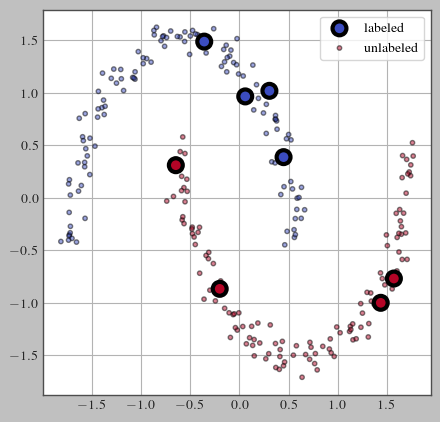

In [45]:
random.seed(1)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=4) + random.sample(indices_class1, k=4)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
unlabeled_ds = torch.utils.data.TensorDataset(X_unlabeled, y_unlabeled)

plt.figure(figsize=(5,5), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=100, edgecolors='black', linewidths=3, label='labeled', zorder=5)
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

In [21]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = 0, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [38]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=100, edgecolors='red', zorder=5)
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

## Pi-Model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 187.69it/s, v_num=33, warmup_factor=1.000, supervised_loss=0.000238, unsupervised_loss=2.47e-5, train_loss=0.000979]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 99: 100%|██████████| 100/100 [00:00<00:00, 187.21it/s, v_num=33, warmup_factor=1.000, supervised_loss=0.000238, unsupervised_loss=2.47e-5, train_loss=0.000979]


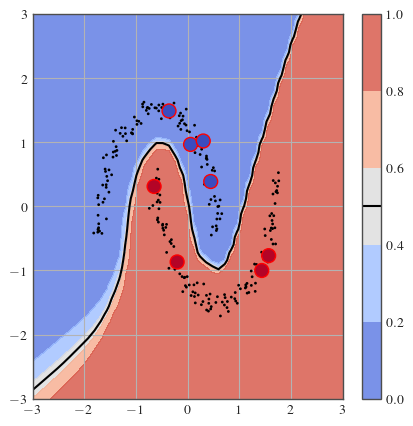

In [46]:
import lightning as L
from dal_toolbox.datasets.ssl_wrapper import PiModelWrapper
from dal_toolbox.models.deterministic.base_semi import DeterministicPiModel
torch.manual_seed(0)

num_epochs = 100 # number of epochs for training
num_iter = 10000 # number of total batches over the whole training
batch_size = 32 # batch_size of labeled samples per iteration
u_ratio = 1 # Ratio of unlabeled samples to labeled samples per batch
lambda_u = 30 # Ratio of unsupervised loss partition to supervised loss of total loss
unsup_warmup = 0.4 # Warm Up Factor for unsupervised loss during training
opt_kwargs = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)

num_iter_per_epoch = num_iter // num_epochs
labeled_sampler = RandomSampler(labeled_ds, num_samples=num_iter_per_epoch*batch_size)
supervised_loader = DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)
unlabeled_ds_weak = PiModelWrapper(unlabeled_ds, '/tmp', transforms_weak=lambda x: x + torch.randn_like(x)*.1)
unlabeled_sampler = RandomSampler(unlabeled_ds_weak, num_samples=u_ratio*num_iter_per_epoch*batch_size)
unsupervised_loader = DataLoader(unlabeled_ds_weak, batch_size=batch_size*u_ratio, sampler=unlabeled_sampler)

model = Net(dropout_rate=0, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), **opt_kwargs)
model = DeterministicPiModel(
    model, 
    num_classes=2, 
    unsup_warmup=unsup_warmup,
    unsup_weight=lambda_u, 
    optimizer=optimizer
)

trainer = L.Trainer(enable_checkpointing=False, max_steps=num_iter)
trainer.fit(model, train_dataloaders={'labeled': supervised_loader, 'unlabeled': unsupervised_loader})

model.eval()
plt.figure(figsize=(5, 5))
plot_contour(model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.show()